In [1]:
# Some code from https://www.kaggle.com/introduction-to-cnn-keras-0-997-top-6 and 
# https://towardsdatascience.com/build-your-own-convolution-neural-network-in-5-mins-4217c2cf964f

import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('/Users/patrickfahy99/Documents/Kaggle_datasets/digit-recognizer/train.csv')
test = pd.read_csv('/Users/patrickfahy99/Documents/Kaggle_datasets/digit-recognizer/test.csv')

y = train['label']
X = train.drop(labels = ['label'] ,axis=1) 

# Normalise the data
X = X / 255.0
test = test / 255.0

# Encode labels to one hot vectors
y = keras.utils.to_categorical(y, num_classes = 10)

# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

random_seed = 42

# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=random_seed)

In [2]:
batch_size = 128
num_classes = 10


# input image dimensions, as there are 784 pixels in the dataset
img_rows, img_cols = 28, 28

# Creating a CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [3]:
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

epochs = 30

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer=optimizer , loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,  
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=False, 
        vertical_flip=False)  


datagen.fit(X_train)

# Fit the model
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(X_val,y_val),
                              verbose=2, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
295/295 - 49s - loss: 0.5633 - accuracy: 0.8208 - val_loss: 0.0812 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 2/30
295/295 - 52s - loss: 0.2366 - accuracy: 0.9284 - val_loss: 0.0698 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 3/30
295/295 - 49s - loss: 0.1814 - accuracy: 0.9463 - val_loss: 0.0543 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 4/30
295/295 - 46s - loss: 0.1553 - accuracy: 0.9551 - val_loss: 0.0457 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 5/30
295/295 - 49s - loss: 0.1373 - accuracy: 0.9604 - val_loss: 0.0376 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 6/30
295/295 - 55s - loss: 0.1277 - accuracy: 0.9634 - val_loss: 0.0381 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 7/30
295/295 - 52s - loss: 0.1211 - accuracy: 0.9657 - val_loss: 0.0423 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 8/30
295/295 - 56s - loss: 0.1161 - accuracy: 0.9669 - val_loss: 0.0388 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 9/30
295/295 - 49s - loss: 0.1129 - accuracy: 0.9673 - val_loss: 0.0330 - val_accu

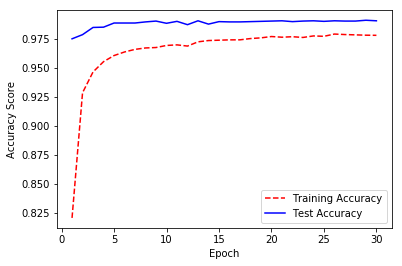

In [5]:
# Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show();

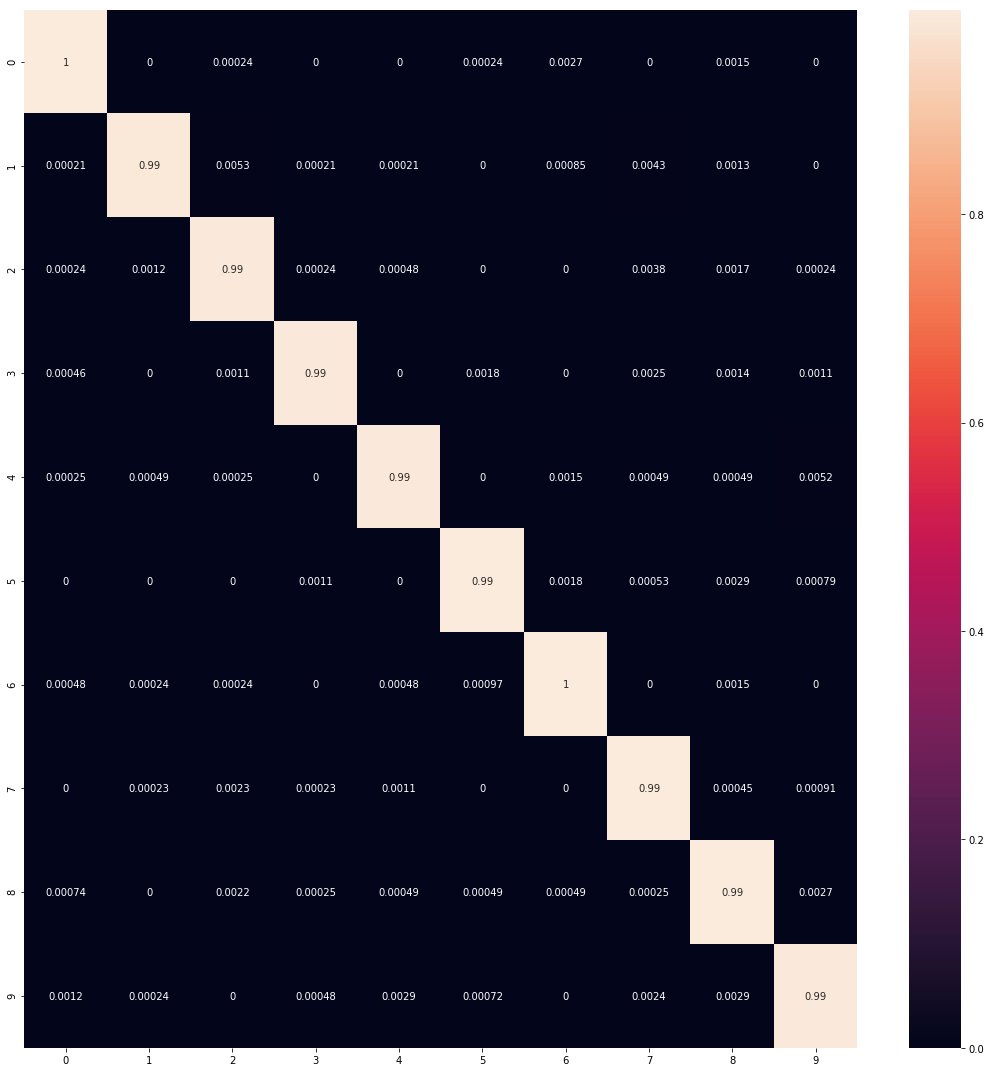

In [6]:
# Creating a normalised confusion matrix

from sklearn.metrics import confusion_matrix

pred = model.predict(X)

y_pred_classes = np.argmax(pred, axis=1) 
y = np.argmax(y,axis=1)

cm = confusion_matrix(y, y_pred_classes, normalize='true') 

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm, ax=ax, annot=True)

fig.tight_layout()
plt.show()

In [7]:
# predict results
pred = model.predict(test)

# select the indix with the maximum probability
pred = np.argmax(pred,axis = 1)

In [8]:
submission = pd.concat([pd.Series(range(1,28001),name = 'ImageId'), pd.DataFrame(pred)], axis=1)

submission.to_csv('/Users/patrickfahy99/Documents/Kaggle_datasets/digit-recognizer/cnn_mnist_datagen.csv',index=False)